In [45]:
import argparse
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plot
#经典组合拳
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets,transforms,models

import torch.optim as optim
from torch.optim import lr_scheduler

torch.manual_seed(0)

#添加参数
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=4, help="size of the batches")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension") #cifar大小32，img_size搞大了它会自动插值
opt = parser.parse_known_args()[0] # opt = parser.parse_args()

#法一，使用torchvision.datasets中的数据集。
dataset = {
    'train':datasets.CIFAR10(
        root="./cifar10/",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(opt.img_size), 
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5])
        ]),
    ),
    'val':datasets.CIFAR10(
        root="./cifar10/",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(opt.img_size), 
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5])
        ]),
    )
}
# b=dataset['train'].test_labels #注意这个是不区分test和train的。。
# c=dataset['train'].train_labels #源码里，test_labels和train_labels指向同一处。
dataloaders={
    x:DataLoader(
        dataset[x],
        batch_size=opt.batch_size,
        shuffle=True,
    ) 
    for x in ['train', 'val']
}

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


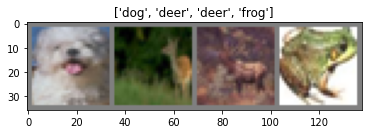

In [52]:
def myshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plot.imshow(inp)
    if title is not None:
        plot.title(title)
    plot.pause(0.001)  # pause a bit so that plots are updated
sample_imgs,sample_labels=next(iter(dataloaders['train']))
myshow(torchvision.utils.make_grid(sample_imgs),[classes[i] for i in sample_labels])

In [38]:
# 加载预训练！对所有参数进行重新训练！叫fine-tune。甚至可以把提取的特征接到svm上，叫迁移学习。
model_ft = models.resnet18(pretrained=True) #默认分521类，预训练！在c盘。
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(),lr=1e-3,betas=(0.9,0.999))
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [83]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #每个周期训练一次，交叉验证一次，会存储交叉验证最好的那一周期的权重。
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  #这玩意只影响bn、dropout之类的

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #如果是True，with包裹的语句要算梯度。
                #如果是false，with包裹的语句不要算梯度。作用只是减少无谓内存消耗
                #和with torch.no_grad(): 是一样的
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{}--- Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
#80%左右正确率

In [ ]:
def visualize_res(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0 #这意思就是随机输出10个图片
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                myshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_res(model_ft)

In [ ]:
# 加载预训练！冻结之前的。这也叫fine-tune
model_ft2 = models.resnet18(pretrained=True) 
for param in model_ft2.parameters():
    param.requires_grad = False
model_ft2.fc = nn.Linear(model_ft2.fc.in_features, 10)

model_ft2 = model_ft2.to(device)
criterion = nn.CrossEntropyLoss()
#解冻fc层参数，只训练这个！大概只要花一半时间，因为forward还是要计算的。
optimizer_ft2 = optim.Adam(model_ft2.fc.parameters(),lr=1e-3,betas=(0.9,0.999))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)

In [ ]:
model_ft2 = train_model(model_ft2, criterion, optimizer_ft2, exp_lr_scheduler,
                       num_epochs=25)
visualize_res(model_ft2)
#在cifar10上用这个方式的迁移学习，只能由50%左右正确率

In [ ]:
#TODO 搞成最小实现形式 参照cgan
#TODO tensorboard
#TODO 查看torchvision的模型目录
#TODO 可视化权重，参照W5-mnist
#TODO 接下来要把中英文文档都看了